# Plot cloud cover impact on the number of observations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
# import rioxarray as rxr
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# load cci lakes
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()
lakes_with_clz = pd.read_csv("../data/lakes_with_climate_zone.csv", index_col = 0)
cci_lakes = pd.read_csv("../data/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv", index_col=0).loc[cci_lake_list]
cci_lakes = pd.concat([cci_lakes, lakes_with_clz.loc[:,["climate_zone"]]], axis = 1)
cci_lakes_gdf = gpd.GeoDataFrame(cci_lakes, geometry=gpd.points_from_xy(cci_lakes['LON CENTRE'], cci_lakes['LAT CENTRE']),
                                crs="epsg:4326")
cci_lakes_gdf.index.name = "cci_lake_id"

In [3]:
train_stats_obs = pd.read_csv("../data/obs_stats_train.csv", index_col = 0)
val_stats_obs = pd.read_csv("../data/obs_stats_val.csv", index_col = 0)
total_stats_obs = pd.read_csv("../data/obs_stats_total.csv", index_col = 0)

In [4]:
# Train period
stat_diff_total = pd.DataFrame([], index = total_stats_obs.index)
# Observational differences cloud  data - daily data
stat_diff_total["obs_diff_mean"] = total_stats_obs["obs_cloud_mean"] - total_stats_obs["obs_mean"]
# load missing training data
stat_diff_total["cloud_frequency"] = 1 - total_stats_obs["valid_proportion"].to_numpy()

In [5]:
stat_diff_total = gpd.GeoDataFrame(pd.concat([cci_lakes_gdf, stat_diff_total], axis = 1))

In [6]:
stat_diff_total["cloud_freq_categorical"] = stat_diff_total.cloud_frequency.apply(lambda x: str(x * 100//10 * 10) + "-" + str(x * 100//10 * 10 + 10) + "%")

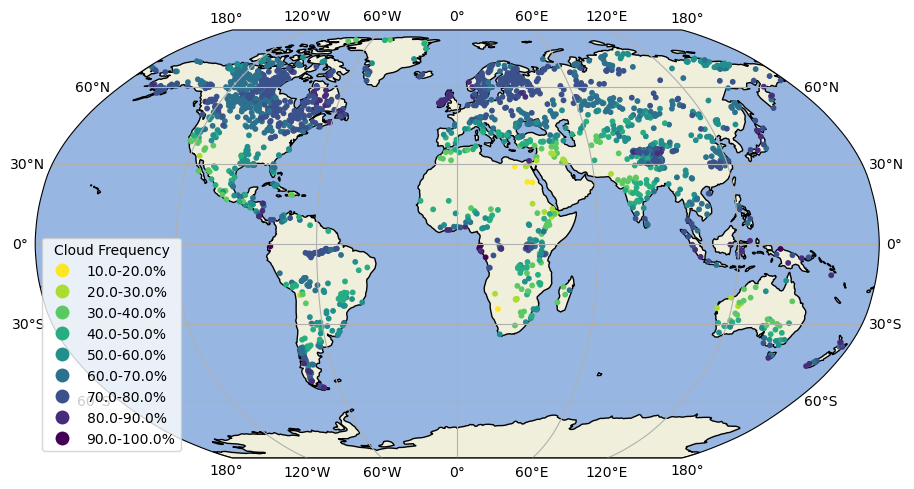

In [7]:
fig = plt.figure(figsize=(10, 5))  # Adjusted the figsize to be wider
nt_proj = ccrs.Robinson()

# change projection
gdf_lakes = stat_diff_total.to_crs(nt_proj)

# fig.suptitle("Bias of Tmean in synthetic observations", y=0.95)

# Geographical distribution of Bias (Left plot)
ax1 = fig.add_subplot(1, 1, 1, projection=nt_proj)
ax1.add_feature(cfeature.OCEAN, zorder=0)
ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
# ax1.set_title("Map of cloud frequency (n = 2016)")
ax1.set_global()
ax1.gridlines(draw_labels=True)

# Plot 
gdf_lakes.plot(column = "cloud_freq_categorical",
        markersize=10,
        cmap="viridis_r",
        missing_kwds={
            "hatch": "///",
            "label": "Cloud frequency",
        },
        legend = True,
        ax=ax1
        )
lgd = ax1.get_legend()
lgd.set_title("Cloud Frequency")
plt.tight_layout()
plt.show()

In [8]:
fig.savefig("../figs/cloud_frequency.png", dpi = 300, bbox_inches='tight')

# Plot most cloudy months